模型：epoch=10 30 50

数据：训练集、测试集、真实不公平集、生成集*3

维度：x-density, y-entropy, color-dataset

In [1]:
from train_dnn import get_data
import torch
from data import adult
from torch.utils.data import DataLoader
from dnn_models.model import MLP
from utils import load_model
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import KernelDensity

def load_data_and_model(model_id, use_protected_attr, protected_vars):
    def get_data_from_loader(loader):
        data = torch.Tensor()
        for batch in loader:
            data = torch.concat([data, batch[0]], dim=0)
        return data
    
    dataset, train_loader, test_loader = get_data(adult, model_id, protected_vars)
    dataset.use_protected_attr = use_protected_attr
    all_data = dataset.get_all_data()
    train_data = get_data_from_loader(train_loader)
    test_data = get_data_from_loader(test_loader)

    in_dim = dataset.dim_feature()
    out_dim = 2

    model = MLP(in_dim, out_dim)
    load_model(model, 'MLP', 'adult', 'STDTrainer', use_protected_attr=use_protected_attr, \
               protected_vars=protected_vars, id=model_id)
    return model, dataset, all_data, train_data, test_data

def get_log_pairs(log_path):
    with open(os.path.join('log', f'{log_path}.log'),'r') as f:
        lines = f.readlines()
        pairs = torch.Tensor()
        for line in lines[1:]:
            if len(line.split('\t')) < 4:
                continue
            t, s, n, p = line.split('\t')
            if p == 'None\n':
                continue
            p = torch.tensor(eval(p))
            pairs = torch.concat([pairs, p], dim=0)
        return torch.Tensor(pairs)

model, dataset, all_X, train_data, test_data = load_data_and_model(0, True, ['sex_Male'])
my_data = get_log_pairs('Causal_race_White_black')
distr_data = get_log_pairs('Causal_race_White_distribution')
range_data = get_log_pairs('Causal_race_White_range')

In [2]:
def marginal_data(data, model):
    prediction = model.get_prediction(data)
    counterfactual_data_sex = data.clone()
    counterfactual_data_race = data.clone()
    counterfactual_data_sex[:, 33] = 1-counterfactual_data_sex[:, 33]
    counterfactual_data_race[:, 26] = 1-counterfactual_data_race[:, 26]
    cf_sex_prediction = model.get_prediction(counterfactual_data_sex)
    cf_race_prediction = model.get_prediction(counterfactual_data_race)
    # print(prediction.shape, cf_sex_prediction.shape)
    # print(prediction != cf_sex_prediction)
    unfair_index_sex = torch.where(cf_sex_prediction != prediction)[0]
    unfair_index_race = torch.where(cf_race_prediction != prediction)[0]

    return data[unfair_index_sex], data[unfair_index_race]

train_sex_unfair_data, train_race_unfair_data = marginal_data(train_data, model)
test_sex_unfair_data, test_race_unfair_data = marginal_data(test_data, model)

In [3]:
data_gen = adult.Adult_gen(sensitive_columns=['sex_Male'], include_protected_feature=True)
def data2feature(data):
    if isinstance(data, torch.Tensor):
        return data_gen._data2feature(data)
    elif isinstance(data, DataLoader):
        feature = torch.Tensor()
        for batch in data:
            feature = torch.concat([feature, data_gen._data2feature(batch[0])])
        return feature

In [4]:
def entropy(data):
    logits = model(data)
    p = torch.softmax(logits, dim=1).detach().numpy()
    e = -np.sum(p * np.log2(p), axis=1)
    return e

e_train = entropy(train_data)
e_test = entropy(test_data)
e_distr = entropy(distr_data)
e_range = entropy(range_data)
e_my = entropy(my_data)
e_train_sex_unfair = entropy(train_sex_unfair_data)
e_train_race_unfair = entropy(train_race_unfair_data)
e_test_sex_unfair = entropy(test_sex_unfair_data)
e_test_race_unfair = entropy(test_race_unfair_data)

In [5]:
data_range = torch.quantile(train_data, torch.Tensor([0, 1]), dim=0)
def data_norm(data):
    l, u = data_range[0], data_range[1]
    return (data - l)/(u - l)

kde = KernelDensity(bandwidth='silverman', kernel='gaussian')
kde.fit(data_norm(train_data))

def log_density(data):
    data = data_norm(data)
    return kde.score_samples(data)

d_train = log_density(train_data)
d_test = log_density(test_data)
d_distr = log_density(distr_data)
d_range = log_density(range_data)
d_my = log_density(my_data)
d_train_sex_unfair = log_density(train_sex_unfair_data)
d_train_race_unfair = log_density(train_race_unfair_data)
d_test_sex_unfair = log_density(test_sex_unfair_data)
d_test_race_unfair = log_density(test_race_unfair_data)

In [6]:
def scatter(density_list, entropy_list, labels, colors, markers):
    fig, ax = plt.subplots(figsize=(8, 8))
    for i in range(len(density_list)):
        d = np.log(-density_list[i])
        e = entropy_list[i]
        ax.scatter(d, e, label=labels[i], c=colors[i], marker=markers[i], alpha=0.1)
    ax.set_xlabel('log(-log(likelyhood))')
    ax.set_ylabel('entropy')
    ax.legend()
    plt.show()

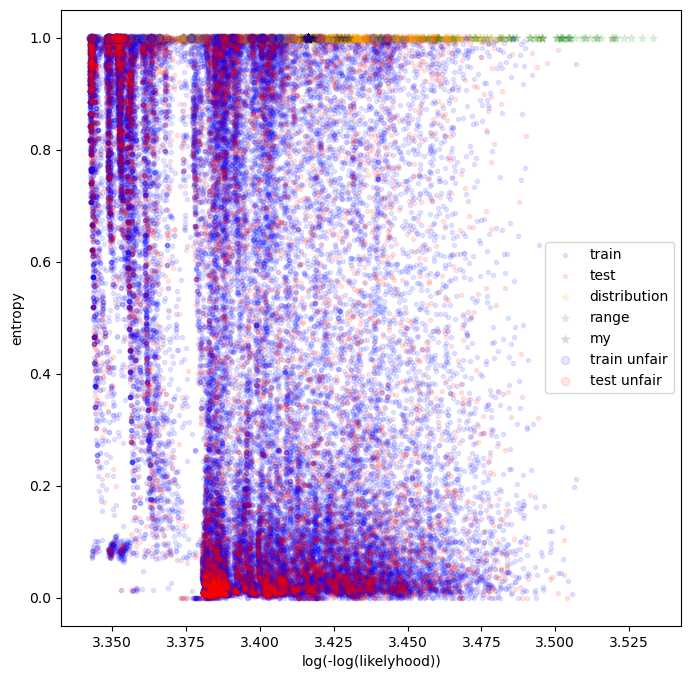

In [7]:
scatter(
    density_list=[d_train, d_test, d_distr, d_range, d_my, d_train_race_unfair, d_test_race_unfair],
    entropy_list=[e_train, e_test, e_distr, e_range, e_my, e_train_race_unfair, e_test_race_unfair],
    labels=['train', 'test', 'distribution', 'range', 'my', 'train unfair', 'test unfair'],
    colors=['blue', 'red', 'orange', 'green', 'black', 'blue', 'red'],
    markers=['.', '.', '*', '*', '*', 'o', 'o']
)

In [9]:
import math
from IPython.display import clear_output
def show_data(data):
    data_len = data.shape[0]
    for i in range(math.ceil(data_len/20)):
        l = 20*i
        r = min(20*(i + 1), data_len)
        display(adult.get_original_feature(data[l : r]))
        input()
        clear_output(())

In [10]:
show_data(my_data)

,age,capital-gain,capital-loss,education-num,hours-per-week,race_White,sex_Male,marital-status,occupation,relationship,workclass
0,90.0,9449.0,0.0,16.0,99.0,1.0,1.0,4.0,7.0,1.0,2.0
1,90.0,9446.0,0.0,16.0,99.0,1.0,1.0,4.0,7.0,1.0,2.0
2,90.0,9450.0,0.0,16.0,99.0,1.0,1.0,4.0,7.0,1.0,2.0
3,90.0,9447.0,0.0,16.0,99.0,1.0,1.0,4.0,7.0,1.0,2.0
4,90.0,9450.0,0.0,16.0,99.0,1.0,1.0,4.0,7.0,1.0,2.0
5,90.0,9447.0,0.0,16.0,99.0,1.0,1.0,4.0,7.0,1.0,2.0
6,90.0,9450.0,0.0,16.0,99.0,1.0,1.0,4.0,7.0,1.0,2.0
7,90.0,9447.0,0.0,16.0,99.0,1.0,1.0,4.0,7.0,1.0,2.0
8,90.0,9449.0,0.0,16.0,99.0,1.0,1.0,4.0,7.0,1.0,2.0
9,90.0,9446.0,0.0,16.0,99.0,1.0,1.0,4.0,7.0,1.0,2.0


KeyboardInterrupt: Interrupted by user

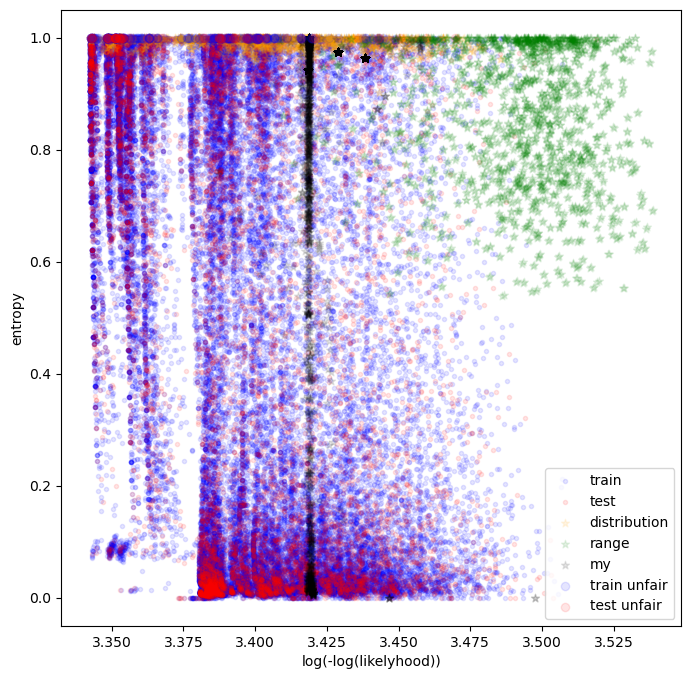

In [14]:
# 10 epochs
scatter(
    density_list=[d_train, d_test, d_distr, d_range, d_my, d_train_race_unfair, d_test_race_unfair],
    entropy_list=[e_train, e_test, e_distr, e_range, e_my, e_train_race_unfair, e_test_race_unfair],
    labels=['train', 'test', 'distribution', 'range', 'my', 'train unfair', 'test unfair'],
    colors=['blue', 'red', 'orange', 'green', 'black', 'blue', 'red'],
    markers=['.', '.', '*', '*', '*', 'o', 'o']
)

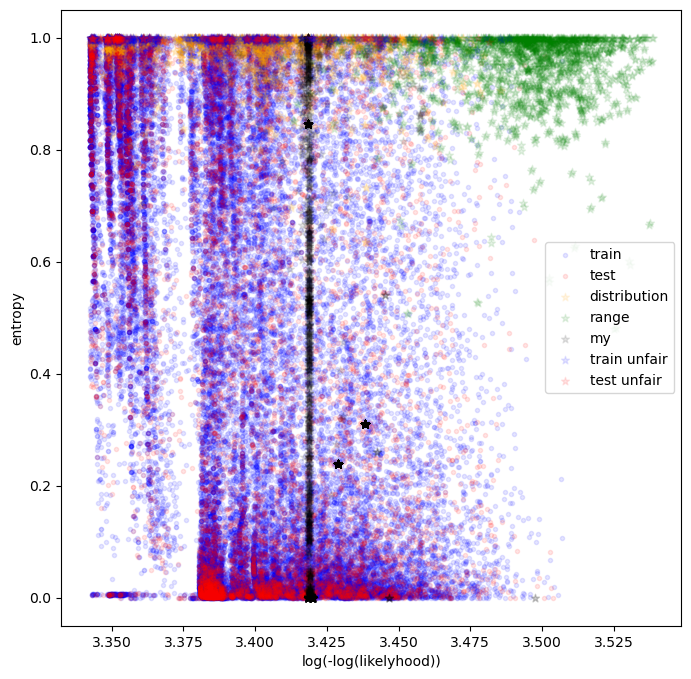

In [7]:
# 30 epochs
scatter(
    density_list=[d_train, d_test, d_distr, d_range, d_my, d_train_race_unfair, d_test_race_unfair],
    entropy_list=[e_train, e_test, e_distr, e_range, e_my, e_train_race_unfair, e_test_race_unfair],
    labels=['train', 'test', 'distribution', 'range', 'my', 'train unfair', 'test unfair'],
    colors=['blue', 'red', 'orange', 'green', 'black', 'blue', 'red'],
    markers=['.', '.', '*', '*', '*', '*', '*']
)

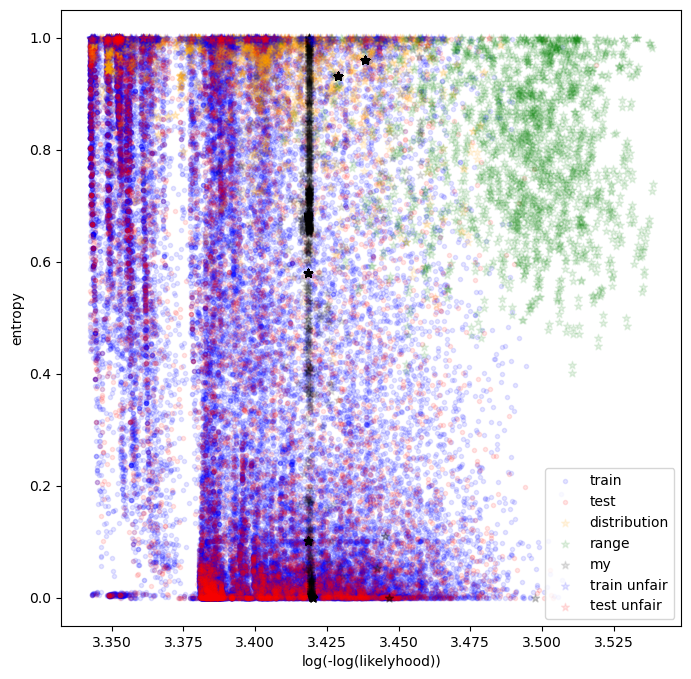

In [9]:
# 50 epochs

scatter(
    density_list=[d_train, d_test, d_distr, d_range, d_my, d_train_race_unfair, d_test_race_unfair],
    entropy_list=[e_train, e_test, e_distr, e_range, e_my, e_train_race_unfair, e_test_race_unfair],
    labels=['train', 'test', 'distribution', 'range', 'my', 'train unfair', 'test unfair'],
    colors=['blue', 'red', 'orange', 'green', 'black', 'blue', 'red'],
    markers=['.', '.', '*', '*', '*', '*', '*']
)